- 웹 크롤링

In [20]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time
import MeCab
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

mpl.rcParams['axes.unicode_minus'] = False #한글폰트로 바꿨을 때 마이너스 폰트 깨짐 방지

In [2]:
driver = webdriver.Chrome('./chromedriver.exe')
driver.implicitly_wait(2)
driver.get("https://www.youtube.com/")

In [3]:
driver.find_element_by_xpath('//*[@id="contents"]/ytd-rich-item-renderer[2]').click()

In [6]:
last_page_height = driver.execute_script("return document.documentElement.scrollHeight")

while True: 
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);") 
    time.sleep(1) 
    new_page_height = driver.execute_script("return document.documentElement.scrollHeight") 
    if new_page_height == last_page_height: 
        break 
    last_page_height = new_page_height 

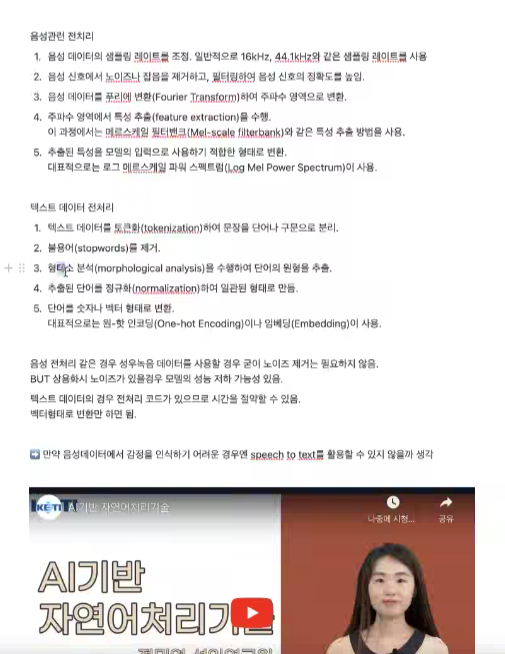

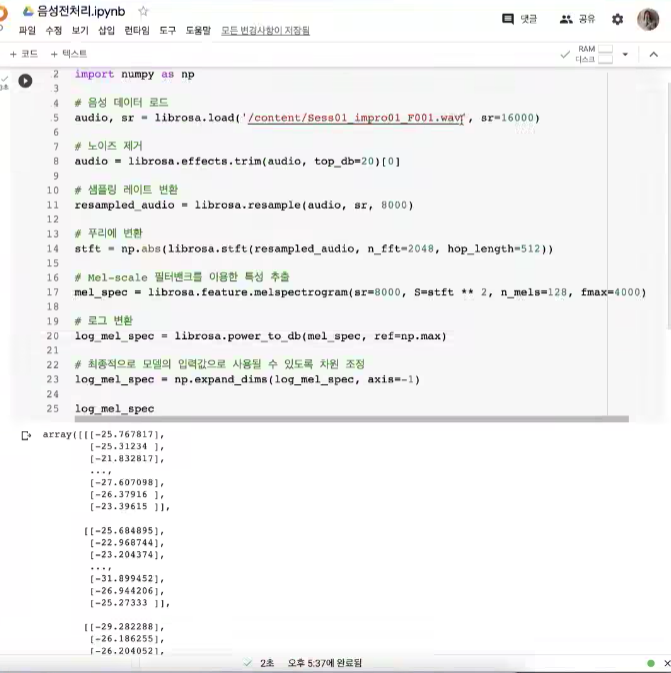

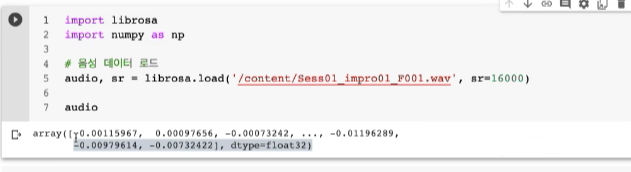

- 이렇게 뽑아도 배열로 나옴
- 우리는 이걸 음성으로 듣지만 컴퓨터는 음성으로 인식 못함
- 그럼 컴퓨터가 알아들을 수 있게 불러오는 방법이 어레이임
- 이진법 이런 걸로 변환하는 것처럼 음성을 넘파이 어레이로 인식해서 가져오는 것임
- 차원 조정도 모델에서 차원이 많을수록 딥러닝은 아닐 텐데 머신러닝 같은 경우엔 인식을 잘 못하는 경우도 있음 차원 관련은 공부해 보시는 게 좋아요


- 텍스트 데이터 전처리

In [7]:
comments=[]
page = driver.page_source
soup = bs(page, 'lxml')
all_comments = soup.find_all(id='expander')
for comment in all_comments:
    try:
        comment_oneline = comment.find(id='content-text').text
        comments.append(comment_oneline)
    except:
        comment_lines = comment.find_all('span', {'class':"style-scope yt-formatted-string"})
        comment = ''
        for line in comment_lines:
            comment += line.text.strip() + ' '
        if len(comment) > 0:
            comments.append(comment)
#<yt-formatted-string id="content-text" slot="content" split-lines="" class="style-scope ytd-comment-renderer">
#<yt-formatted-string id="content-text" slot="content" split-lines="" class="style-scope ytd-comment-renderer">제목 바꿧네 ㅋㅋㅋ</yt-formatted-string>

In [8]:
print(len(comments), comments)

345 ['안녕하세요 수프 채널 애청자, 구독자 여러분!\r\n\r런던에서 녹음해 온 소리 두 번째는\n\n영국 도서관의 입체 음향입니다.\r\n \n열람실 소리도 녹음하고 싶었는데 \r\n열람실에 마이크 같은\r\n전자 기기 반입이 안된다고 하더라고요.\r\n서가 출입증 발급 받으려고 여기저기 알아보고\r\n서류도 준비했는데 소용이 없었네요.ㅠ\r\n \n하지만 집중력에는 적당한 소음이 도움이 되고\r\n조용한 열람실 보다는\r\n이쪽이 공부할 땐 더 낫다는 생각이 들어요.\r\n \n영국 도서관 로비와 카페테리아에는\r\n과제를 하거나 공부를 하는 사람들이 정말 많아요.\r\n저도 녹음하는 동안 책을 열심히 읽을 수 있었답니다.\r\n \n테스트로 들어 보니 집중도 잘 되고 시간도 정말 잘 가네요.\r\n공부할 때 뿐만아니라 작업할 때도,\r\n책을 읽을 때도 정말 좋은 소리라고 생각해요.\r\n \n요즘 기말고사 기간이라고 들었는데\r\n부디 도움이 됐으면 합니다. :) \r\n \n \n \n● 5월 후원해 주신,\r\n \n혜수님, 루시, 효정님, 유민님\r\n \n진심으로 감사드립니다! :)\r\n \nSpecial Thanks For 효정님!\r\n지난 달에 이어 또 큰 후원 보내주셨어요ㅠ\r\n \n \n \n●공지!\r\n \n최근 수프가 일상 채널 브이로그(도쿄)를 오픈했어요.\r\n많이 많이 놀러 오시고 응원해 주세요! :)\r\n \nhttps://www.youtube.com/channel/UCObEKWaIitNu00ZXxJ9vYsA\r\n \n \n \n--- \r\n \n \n \n따끈따끈한 방송을 빨리 보시려면\r\n구독하기+알림 설정 꼭 해 주세요! : )\r\n \n● ASMR 제작 의견을 남기시려면↓\r\nhttps://goo.gl/forms/mFHBtIdphz1rAvdR2\r\n \n정리하기 쉽고 어떤 내용이 많은지 통계 내기도 수월할 것 같아\r\n앞으로 위 설문지를 통해서만 의견을 받도록 하겠습니다! :)\r\n의견은 하나

In [9]:
def getNVM_lemma(text):
    tokenizer = MeCab.Tagger()
    parsed = tokenizer.parse(text)
    word_tag = [w for w in parsed.split("\n")]
    pos = []
    tags = ['NNG', 'NNP', 'VV', 'VA', 'VX', 'VCP', 'VCN', 'MAG']
    for word_ in word_tag[:-2]:
        word = word_.split("\t")
        tag = word[1].split(",")
        if(tag[0] in tags):
            pos.append(word[0])
        elif('+' in tag[0]): #단어가 여러 형태소로 구성된 경우
            if('VV' in tag[0] or 'VA' in tag[0] or 'VX' in tag[0]):
                t = tag[-1].split('/')[0]
                pos.append(t)
    return pos

def main():
    s = '우리는 가까워질 수 없기 때문에 가깝게 느껴지지 않는다'
    print(getNVM_lemma(s))
    
main()

['가깝', '없', '가깝', '느끼', '지', '않']


In [10]:
# 텍스트를 여기에 for문 돌리면 된다.
morphemes = []
for comment in comments:
    comment_morph = getNVM_lemma(comment)
    print(comment_morph)
    morphemes += comment_morph

['안녕', '수프', '채널', '애청자', '구독자', '런던', '녹음', '오', '소리', '영국', '도서관', '입체', '음향', '열람실', '소리', '녹음', '싶', '열람실', '마이크', '같', '전자', '기기', '반입', '안', '되', '하', '서가', '출입증', '발급', '받', '여기저기', '알아보', '서류', '준비', '소용', '없', '하', '집중력', '소음', '도움', '되', '열람실', '공부', '더', '낫', '생각', '들', '영국', '도서관', '로비', '카페테리아', '과제', '하', '공부', '하', '사람', '정말', '많', '녹음', '동안', '책', '열심히', '읽', '있', '테스트', '들', '보', '집중', '잘', '되', '시간', '정말', '잘', '가', '공부', '때', '아니', '작업', '때', '책', '읽', '때', '정말', '좋', '소리', '생각', '요즘', '기말고사', '기간', '이', '들', '부디', '도움', '되', '하', '후원', '주', '혜', '수', '루시', '효정', '유민', '진심', '감사', '드리', '효정', '지나', '달', '이어', '또', '크', '후원', '보내', '주', '공지', '최근', '수프', '일상', '채널', '브이', '도쿄', '오픈', '많이', '많이', '놀', '오', '응원', '주', '따끈따끈', '방송', '빨리', '보', '구독', '알리', '설정', '꼭', '하', '주', '제작', '의견', '남기', '정리', '쉽', '내용', '많', '통계', '내', '수월', '같', '앞', '위', '설문지', '통하', '의견', '받', '하', '의견', '빼놓', '않', '읽', '보', '있', '걱정', '말', '수프', '채널', '후원', '구글', '유튜브', '계정', '이용', '보내', '주', 

In [11]:
morpheme_nums = {}
for i in morphemes:
    if i in morpheme_nums:
        morpheme_nums[i] += 1
    else:
        morpheme_nums.update({i:1})
morph_sorted = sorted(morpheme_nums.items(), key=(lambda x:x[1]), reverse = True)
print(morph_sorted, type(morph_sorted))

[('공부', 151), ('하', 129), ('감사', 125), ('있', 111), ('듣', 106), ('수프', 103), ('좋', 94), ('되', 86), ('잘', 83), ('소리', 82), ('이', 77), ('도서관', 69), ('너무', 65), ('보', 61), ('주', 61), ('영상', 60), ('진짜', 58), ('집중', 57), ('같', 55), ('영국', 51), ('가', 48), ('때', 40), ('시험', 37), ('항상', 35), ('정말', 32), ('오', 30), ('안', 30), ('ㄷ', 30), ('들', 29), ('알', 27), ('들리', 26), ('덕분', 24), ('소음', 23), ('오늘', 21), ('기간', 20), ('말', 19), ('지금', 19), ('열심히', 17), ('시간', 17), ('리얼', 17), ('없', 16), ('더', 16), ('사람', 16), ('옆', 16), ('집', 16), ('런던', 15), ('많이', 15), ('느낌', 13), ('카페', 13), ('드리', 12), ('크', 12), ('않', 12), ('기분', 12), ('올리', 12), ('사랑', 12), ('늘', 12), ('싶', 11), ('최고', 11), ('못', 11), ('딱', 11), ('영어', 11), ('계속', 11), ('이렇게', 11), ('넘', 11), ('생각', 10), ('대박', 10), ('왜', 10), ('다시', 10), ('시끄럽', 10), ('댓글', 10), ('앉', 10), ('나', 10), ('녹음', 9), ('읽', 9), ('직접', 9), ('학생', 9), ('곳', 9), ('전', 9), ('찾', 9), ('열공', 9), ('혼자', 9), ('이어폰', 9), ('다', 9), ('음향', 8), ('열람실', 8), ('도움', 8), ('많', 

['NanumSquare_ac']


<BarContainer object of 25 artists>

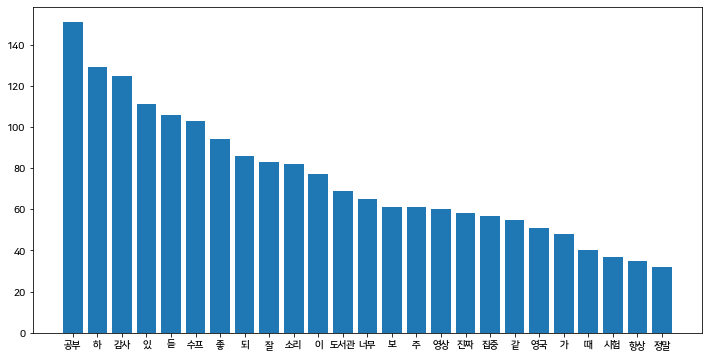

In [13]:
top20_keys = list(itertools.islice(morph_sorted, 25))
#morph_top20 = {i: morph_sorted[i] for i in top20_keys}
morph_top20 = dict(top20_keys)

plt.rc('font', family='NanumSquare_ac') # For Windows
print(plt.rcParams['font.family'])

fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(111)

ax.bar(*zip(*morph_top20.items()))

In [14]:
top20_keys

[('공부', 151),
 ('하', 129),
 ('감사', 125),
 ('있', 111),
 ('듣', 106),
 ('수프', 103),
 ('좋', 94),
 ('되', 86),
 ('잘', 83),
 ('소리', 82),
 ('이', 77),
 ('도서관', 69),
 ('너무', 65),
 ('보', 61),
 ('주', 61),
 ('영상', 60),
 ('진짜', 58),
 ('집중', 57),
 ('같', 55),
 ('영국', 51),
 ('가', 48),
 ('때', 40),
 ('시험', 37),
 ('항상', 35),
 ('정말', 32)]

In [21]:
docs = pd.DataFrame(comments)
print(docs)

                                                     0
0    안녕하세요 수프 채널 애청자, 구독자 여러분!\r\n\r런던에서 녹음해 온 소리 두...
1                               도서관에서 도서관 백색소음을 듣는 나..
2    대박 수프님 덕분에 오늘도 상상하면서 공부합니다...나는 영국의 똑똑한 대학생이다....
3    와 직접 영국에 가는 클라스,,ㄷ ㄷ ;;\n진짜 넘사벽\n완전 소리도좋고 빠져들어...
4    엄마,,, 나 영국여행 공짜로 하고있어,,,걔쩔어,,,이젠 무서울지경......내가...
..                                                 ...
340                       https://youtu.be/C9qLwYTyzr8
341  스터디카페에서 이거 틀어놓은거 깜빡하고 공부하다가 어떤사람이 큰소리로 전화영어하는줄...
342  내일 수행평가를 2개나 쳐서 막막했는데 때맞춰 올려주시네요ㅠㅠ 당신은 도대체... ...
343  여태 들었던 asmr중에 제일 공부 잘되네요 최고! 첨으로 댓글도 남겨요 히히 감사합니다
344  와..여기 저 영국에서 지낼 때 자주 가서 1파운드짜리 티 시켜서 앉아 공부하던 곳...

[345 rows x 1 columns]


In [23]:
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(2,2), min_df=2)
dtm = tf_vect.fit_transform(docs[0])


In [24]:
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()
words = sorted(vocab.items(), key = lambda x:x[1], reverse = True)

['NanumSquare_ac']


C:\Users\SYKim\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


<BarContainer object of 25 artists>

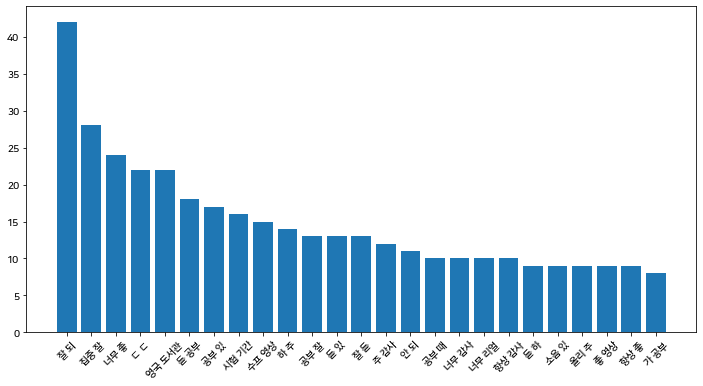

In [30]:
top25_keys = list(itertools.islice(words, 25))
#morph_top20 = {i: morph_sorted[i] for i in top20_keys}
morph_top25 = dict(top25_keys)

plt.rc('font', family='NanumSquare_ac') # For Windows
print(plt.rcParams['font.family'])

fig = plt.figure(figsize = (12,6))
plt.xticks(rotation=45)

ax = fig.add_subplot(111)

ax.bar(*zip(*morph_top25.items()))

- 전체 파일 반복하는 방법
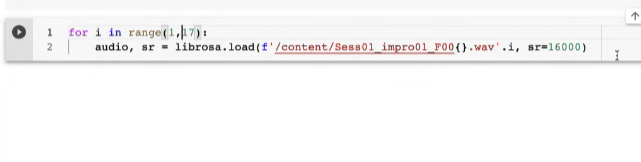

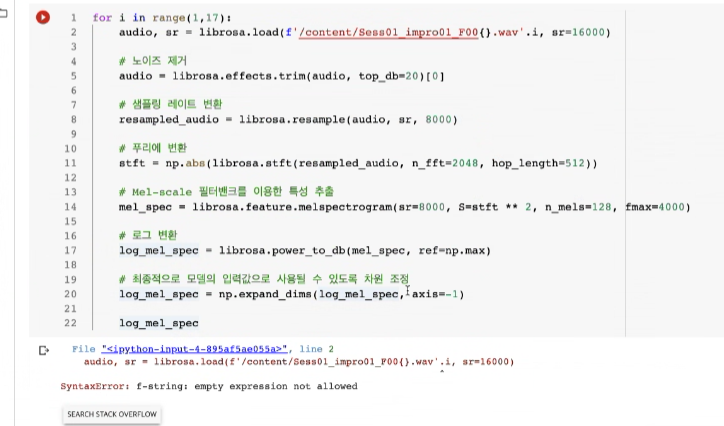
이렇게 하고 df로 저장하면 문서화가 되겠죠